In [1]:
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats
from pmdarima import auto_arima
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
gdpData = pd.read_csv('RealGDPQuarterly.csv')
exchangeData = pd.read_csv('QuarterlyExchangeRate.csv')
inflationData = pd.read_csv('QuarterlyInflationRate.csv')
RainData = pd.read_csv('Rainfall.csv')
df = pd.read_csv('crude-oil-price.csv')
storm = pd.read_csv('storms.csv')

In [3]:
df

,date,price,percentChange,change
0,1984-01-01 00:00:00+00:00,29.98,1.284,0.38
1,1984-02-01 00:00:00+00:00,30.55,1.901,0.57
2,1984-03-01 00:00:00+00:00,30.85,0.982,0.30
3,1984-04-01 00:00:00+00:00,30.26,-1.912,-0.59
4,1984-05-01 00:00:00+00:00,30.83,1.884,0.57
...,...,...,...,...
475,2023-08-01 00:00:00+00:00,82.96,2.017,1.64
476,2023-09-01 00:00:00+00:00,88.80,7.040,5.84
477,2023-10-01 00:00:00+00:00,80.50,-9.347,-8.30
478,2023-11-01 00:00:00+00:00,76.05,-5.528,-4.45


In [4]:
# Convert the date column to proper datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract the month from each date and create a new column 'Months'
df['Months'] = df['date'].dt.month
df['Years'] = df['date'].dt.year

In [5]:
df

,date,price,percentChange,change,Months,Years
0,1984-01-01 00:00:00+00:00,29.98,1.284,0.38,1,1984
1,1984-02-01 00:00:00+00:00,30.55,1.901,0.57,2,1984
2,1984-03-01 00:00:00+00:00,30.85,0.982,0.30,3,1984
3,1984-04-01 00:00:00+00:00,30.26,-1.912,-0.59,4,1984
4,1984-05-01 00:00:00+00:00,30.83,1.884,0.57,5,1984
...,...,...,...,...,...,...
475,2023-08-01 00:00:00+00:00,82.96,2.017,1.64,8,2023
476,2023-09-01 00:00:00+00:00,88.80,7.040,5.84,9,2023
477,2023-10-01 00:00:00+00:00,80.50,-9.347,-8.30,10,2023
478,2023-11-01 00:00:00+00:00,76.05,-5.528,-4.45,11,2023


In [6]:
dataYear = df[(df['Years'] >= 2000) & (df['Years'] <= 2023)] 
dataYear.head(10)

,date,price,percentChange,change,Months,Years
192,2000-01-01 00:00:00+00:00,27.64,7.969,2.04,1,2000
193,2000-02-01 00:00:00+00:00,30.43,10.094,2.79,2,2000
194,2000-03-01 00:00:00+00:00,26.90,-11.600,-3.53,3,2000
195,2000-04-01 00:00:00+00:00,25.74,-4.312,-1.16,4,2000
196,2000-05-01 00:00:00+00:00,29.01,12.704,3.27,5,2000
197,2000-06-01 00:00:00+00:00,32.50,12.030,3.49,6,2000
198,2000-07-01 00:00:00+00:00,27.43,-15.600,-5.07,7,2000
199,2000-08-01 00:00:00+00:00,33.12,20.744,5.69,8,2000
200,2000-09-01 00:00:00+00:00,30.84,-6.884,-2.28,9,2000
201,2000-10-01 00:00:00+00:00,32.70,6.031,1.86,10,2000


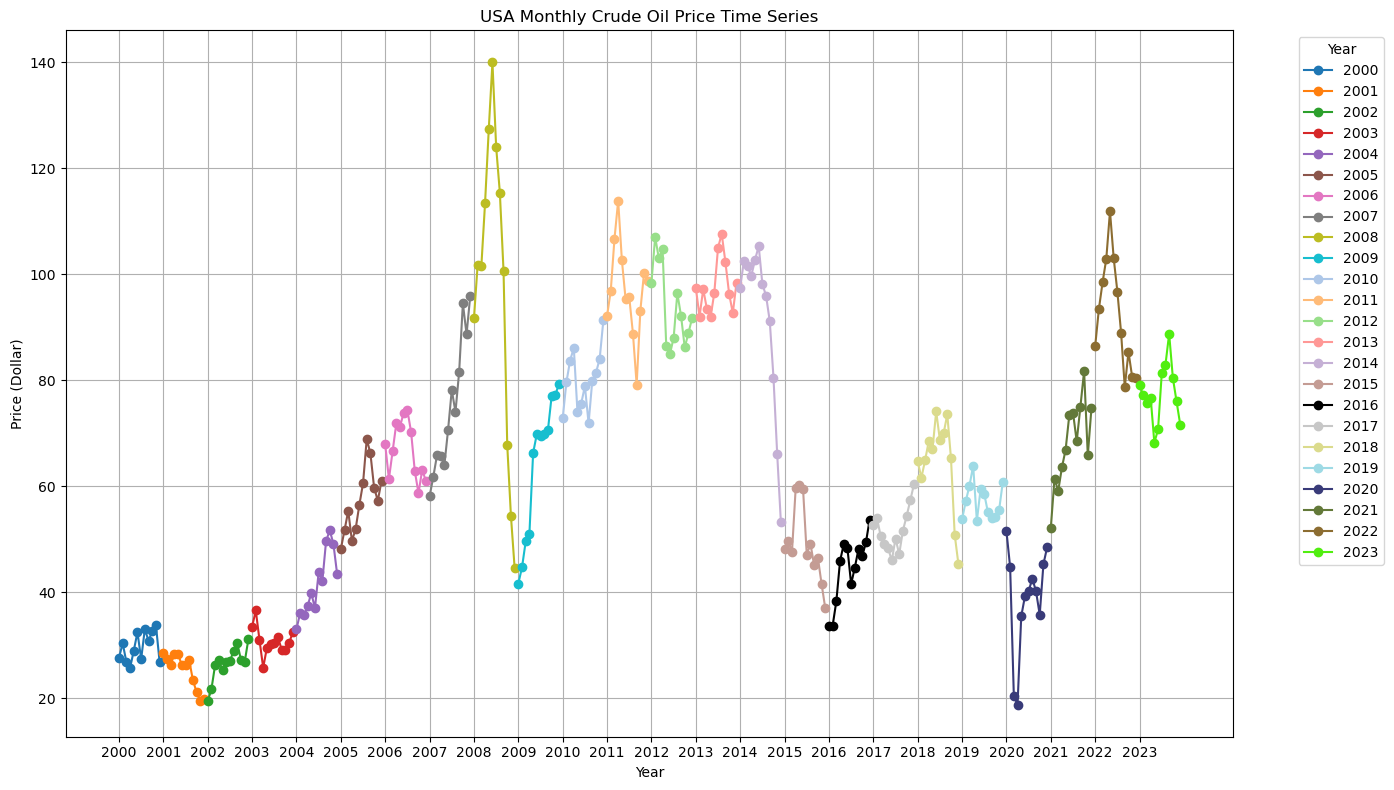

In [7]:
gf = pd.DataFrame(dataYear)

gf['Price'] = pd.to_numeric(gf['price'])

# Sorting the DataFrame by 'Year' and then by 'Month'
df_sorted = gf.sort_values(by=['Years', 'Months', 'price'])

# Creating a new x-axis based on year with small offsets for each month
df_sorted['Year_Month'] = df_sorted['Years'] + (df_sorted['Months'] - 1) / 12

# Define 23 colors
colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', 
    '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', 
    '#c5b0d5', '#c49c94', '#000000', '#c7c7c7', '#dbdb8d', '#9edae5', '#393b79', 
    '#637939', '#8c6d31','#51ee10'
]

# Plotting the data
plt.figure(figsize=(14, 8))

# Plot each year separately to create labels for the legend
for i, year in enumerate(df_sorted['Years'].unique()):
    yearly_data = df_sorted[df_sorted['Years'] == year]
    plt.plot(yearly_data['Year_Month'], yearly_data['price'], marker='o', linestyle='-', label=str(year), color=colors[i % len(colors)])

# Customizing the x-axis to show years as major ticks
years = df_sorted['Years'].unique()
plt.xticks(ticks=years, labels=years)

plt.xlabel('Year')
plt.ylabel('Price (Dollar)')
plt.title('USA Monthly Crude Oil Price Time Series')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
dat2002 = df[(df['Years'] == 2001)] 

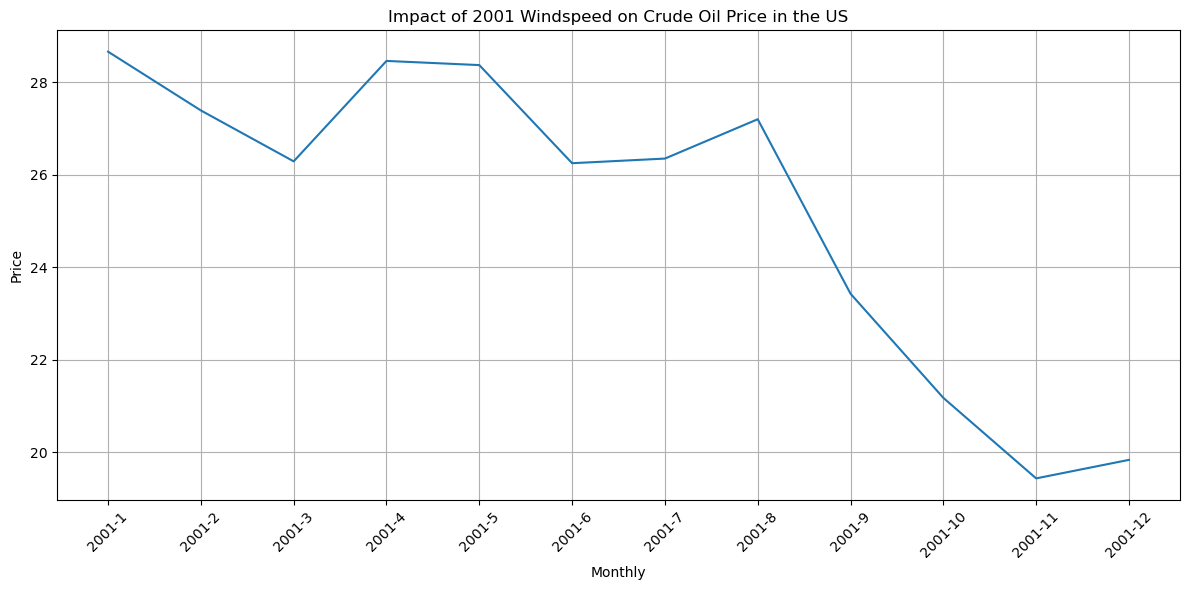

In [9]:
dataYear2 = pd.DataFrame(dat2002)

# Merge columns
dataYear2['Year_Month'] = dataYear2['Years'].astype(str) + '-' + dataYear2['Months'].astype(str)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(dataYear2['Year_Month'], dataYear2['price'], marker='', linestyle='-')
plt.title('Impact of 2001 Windspeed on Crude Oil Price in the US')
plt.xlabel('Monthly')
plt.ylabel('Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
dat2008 = df[(df['Years'] >= 2004) & (df['Years'] <= 2008)] 

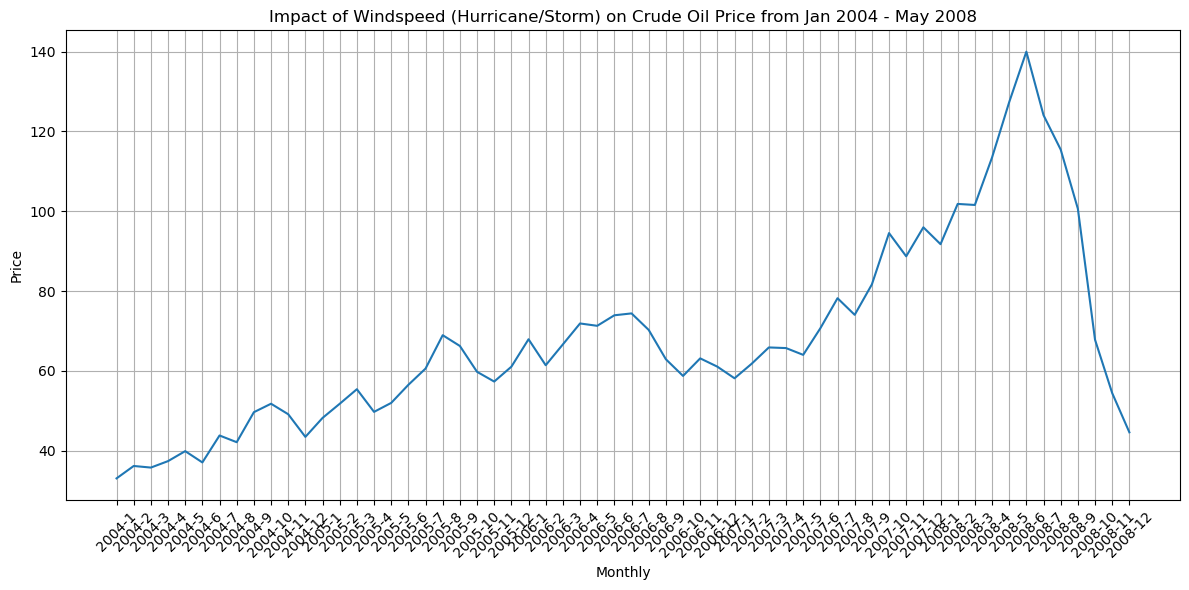

In [11]:
dataYear3 = pd.DataFrame(dat2008)

# Merge columns
dataYear3['Year_Month'] = dataYear3['Years'].astype(str) + '-' + dataYear3['Months'].astype(str)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(dataYear3['Year_Month'], dataYear3['price'], marker='', linestyle='-')
plt.title('Impact of Windspeed (Hurricane/Storm) on Crude Oil Price from Jan 2004 - May 2008')
plt.xlabel('Monthly')
plt.ylabel('Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
dat2008_2 = df[(df['Years'] == 2005)] 

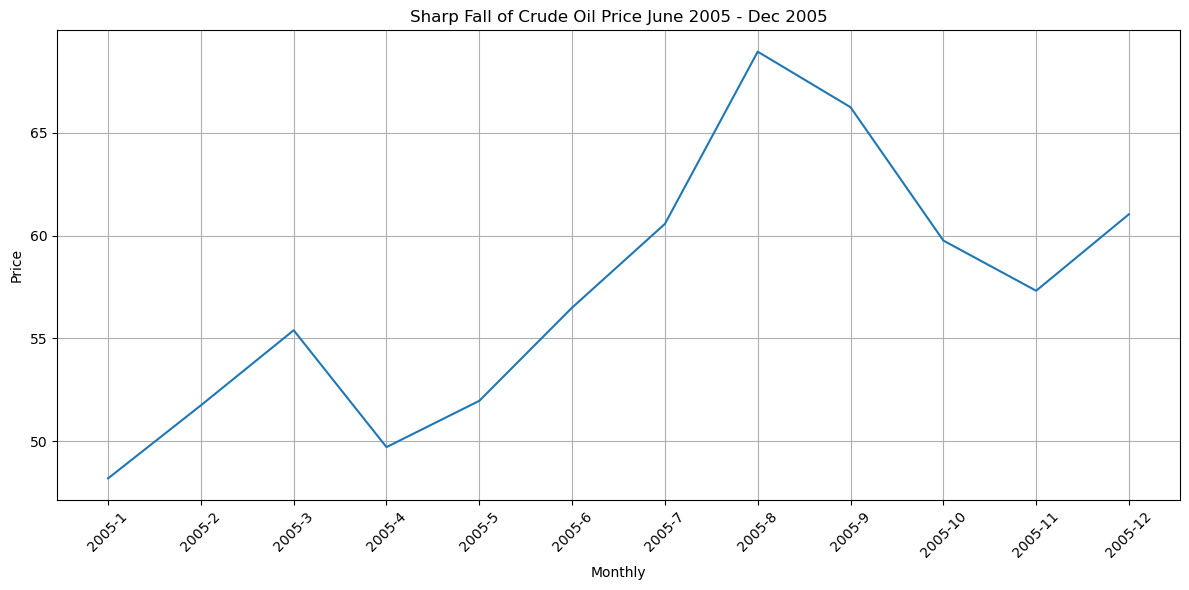

In [13]:
dataYear2 = pd.DataFrame(dat2008_2)

# Merge columns
dataYear2['Year_Month'] = dataYear2['Years'].astype(str) + '-' + dataYear2['Months'].astype(str)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(dataYear2['Year_Month'], dataYear2['price'], marker='', linestyle='-')
plt.title('Sharp Fall of Crude Oil Price June 2005 - Dec 2005')
plt.xlabel('Monthly')
plt.ylabel('Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
dat2011 = df[(df['Years'] >= 2009) & (df['Years'] <= 2011)] 

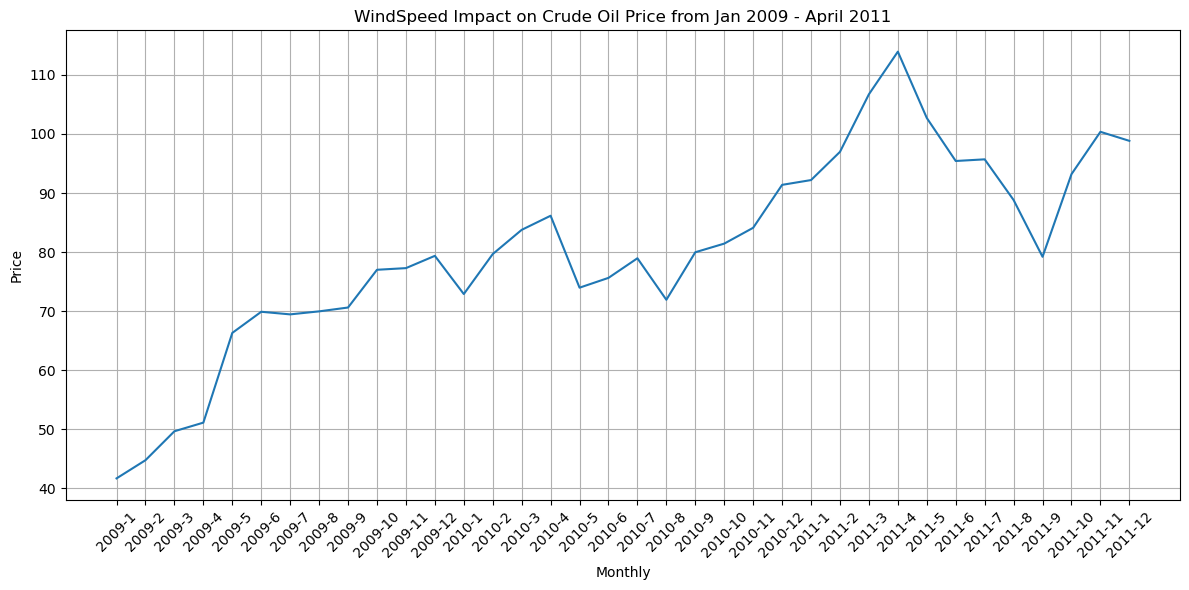

In [15]:
dataYear4 = pd.DataFrame(dat2011)

# Merge columns
dataYear4['Year_Month'] = dataYear4['Years'].astype(str) + '-' + dataYear4['Months'].astype(str)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(dataYear4['Year_Month'], dataYear4['price'], marker='', linestyle='-')
plt.title('WindSpeed Impact on Crude Oil Price from Jan 2009 - April 2011')
plt.xlabel('Monthly')
plt.ylabel('Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
dat2022 = df[(df['Years'] >= 2022) & (df['Years'] <= 2023)] 

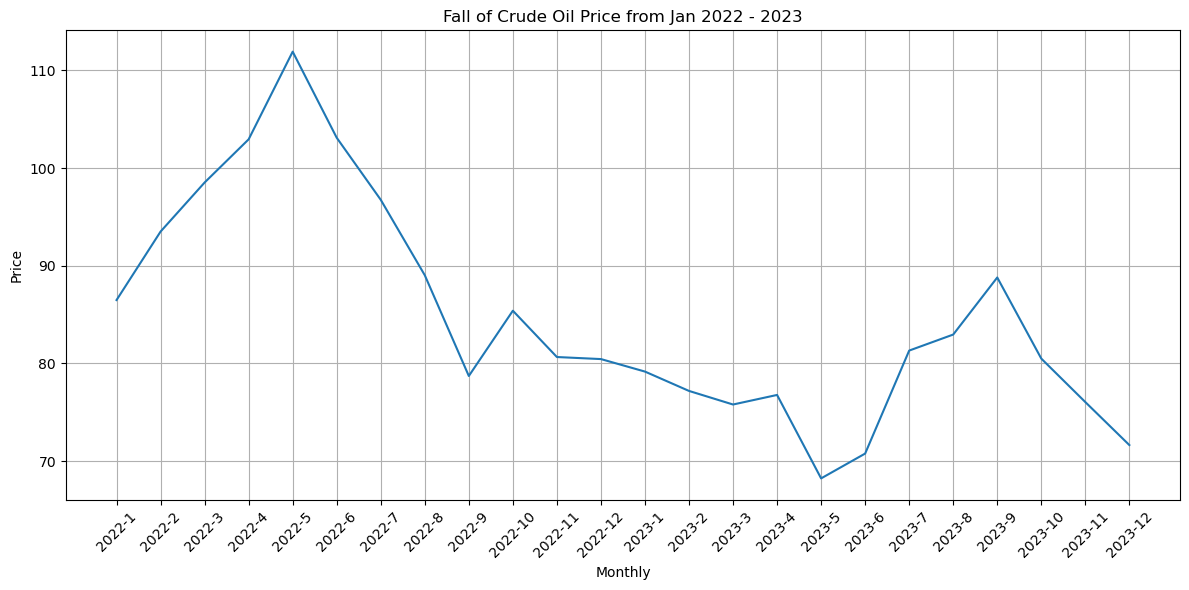

In [17]:
dataYear4 = pd.DataFrame(dat2022)

# Merge columns
dataYear4['Year_Month'] = dataYear4['Years'].astype(str) + '-' + dataYear4['Months'].astype(str)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(dataYear4['Year_Month'], dataYear4['price'], marker='', linestyle='-')
plt.title('Fall of Crude Oil Price from Jan 2022 - 2023')
plt.xlabel('Monthly')
plt.ylabel('Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
storm2002 = storm[(storm['year'] == 2001)] 

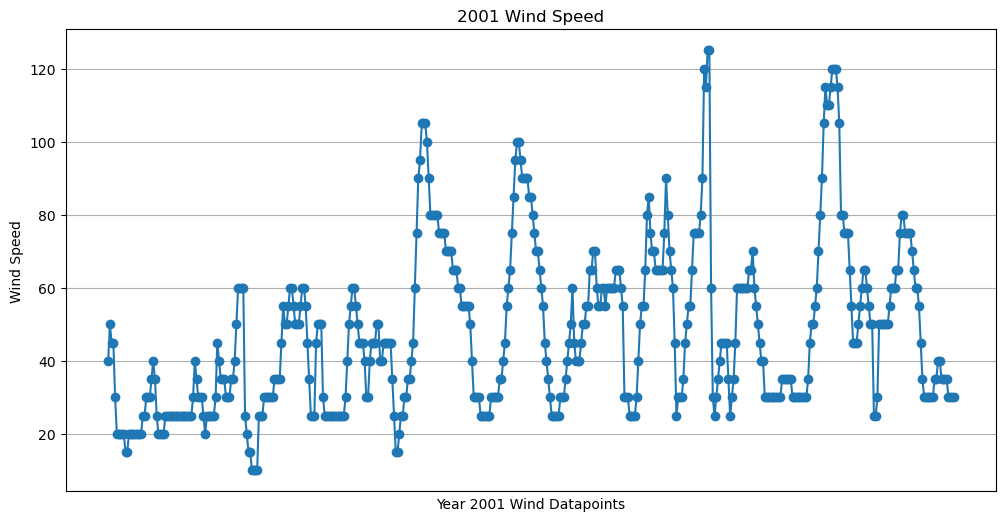

In [19]:
# Create the plot for wind time series
plt.figure(figsize=(12, 6))
plt.plot(storm2002['SN'], storm2002['wind'], marker='o', linestyle='-')
plt.xlabel('Year 2001 Wind Datapoints')
plt.xticks([])
plt.ylabel('Wind Speed')
plt.title('2001 Wind Speed')
plt.grid(True)
plt.show()

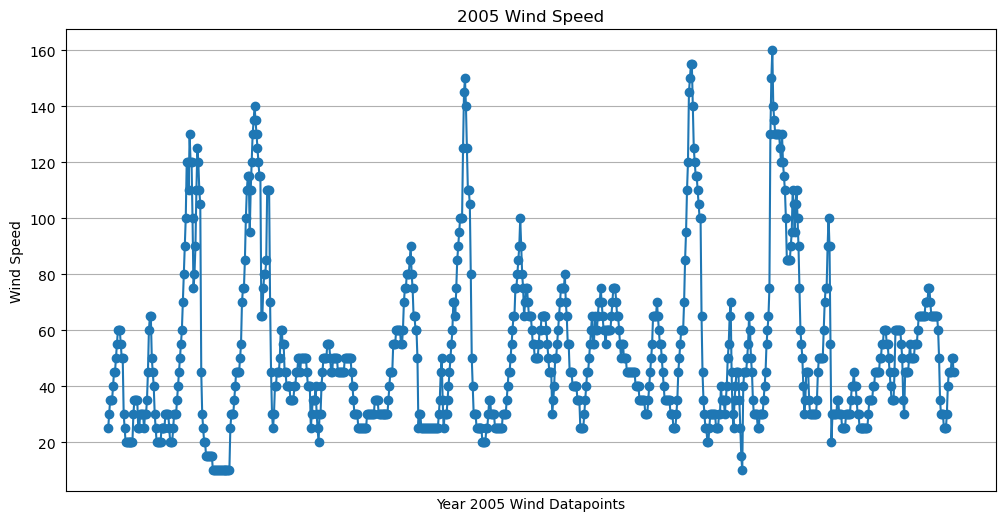

In [20]:
storm2002 = storm[(storm['year'] == 2005)] 
# Create the plot for wind time series
plt.figure(figsize=(12, 6))
plt.plot(storm2002['SN'], storm2002['wind'], marker='o', linestyle='-')
plt.xlabel('Year 2005 Wind Datapoints')
plt.xticks([])
plt.ylabel('Wind Speed')
plt.title('2005 Wind Speed')
plt.grid(True)
plt.show()

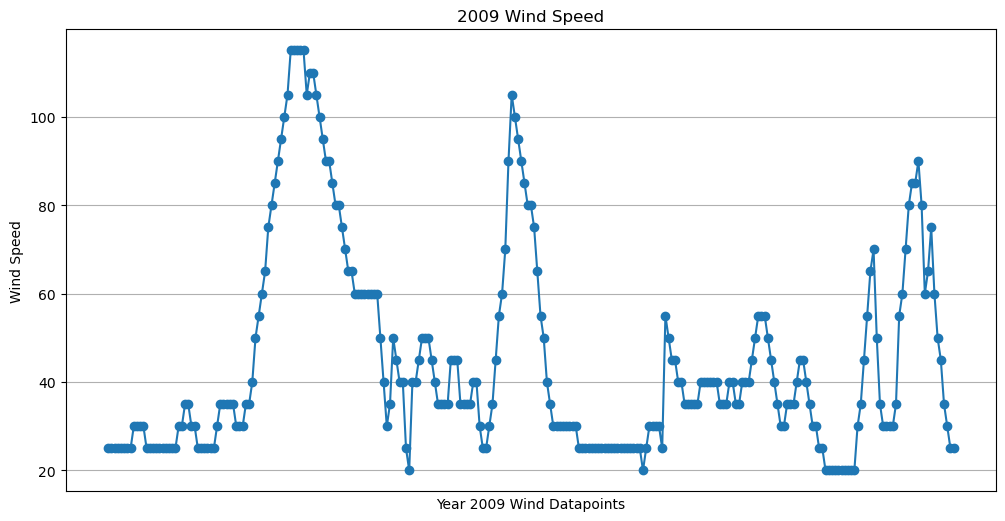

In [21]:
storm2002 = storm[(storm['year'] == 2009)] 
# Create the plot for wind time series
plt.figure(figsize=(12, 6))
plt.plot(storm2002['SN'], storm2002['wind'], marker='o', linestyle='-')
plt.xlabel('Year 2009 Wind Datapoints')
plt.xticks([])
plt.ylabel('Wind Speed')
plt.title('2009 Wind Speed')
plt.grid(True)
plt.show()

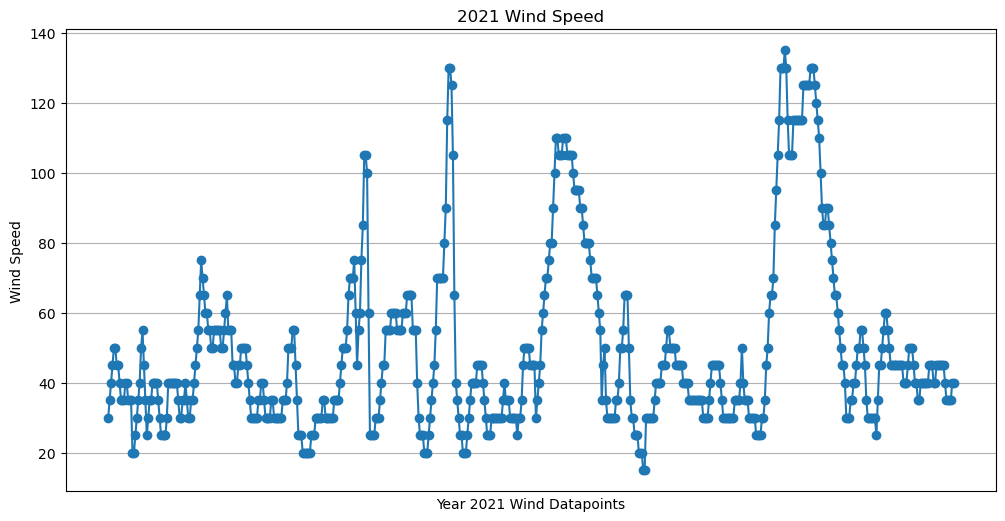

In [22]:
storm2022 = storm[(storm['year'] == 2021)] 
# Create the plot for wind time series
plt.figure(figsize=(12, 6))
plt.plot(storm2022['SN'], storm2022['wind'], marker='o', linestyle='-')
plt.xlabel('Year 2021 Wind Datapoints')
plt.xticks([])
plt.ylabel('Wind Speed')
plt.title('2021 Wind Speed')
plt.grid(True)
plt.show()

In [23]:
# Calculate Z-scores
dataYear['z_score'] = (dataYear['price'] - dataYear['price'].mean()) / dataYear['price'].std()

# Identify outliers
outliers = dataYear[np.abs(dataYear['z_score']) > 3]


# Remove the outliers
Remove_Outlier = dataYear[(np.abs(dataYear['z_score']) <= 3)]

# Drop the Z-score columns as they are no longer needed
Dff_DropColumn = Remove_Outlier.drop(columns=['z_score'])


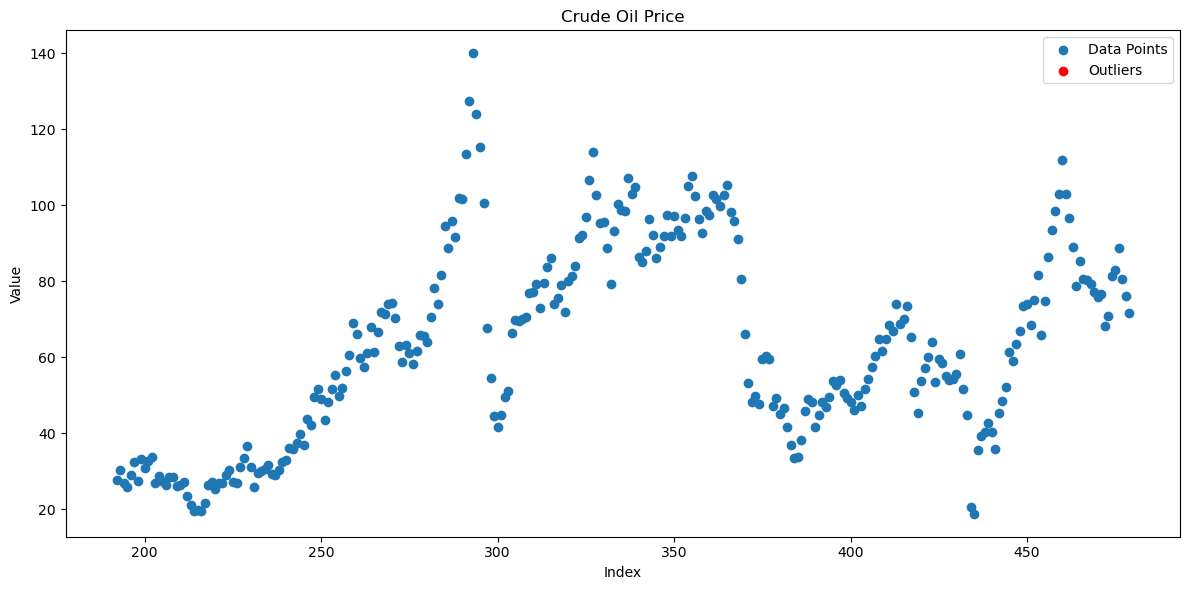

In [24]:
# Create a single plot
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter plot for data points
ax.scatter(dataYear.index, dataYear['price'], label='Data Points')
# Scatter plot for outliers
ax.scatter(outliers.index, outliers['price'], color='red', label='Outliers')

# Setting labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Value')
ax.legend()
ax.set_title('Crude Oil Price')

# Show the plot
plt.tight_layout()
plt.show()

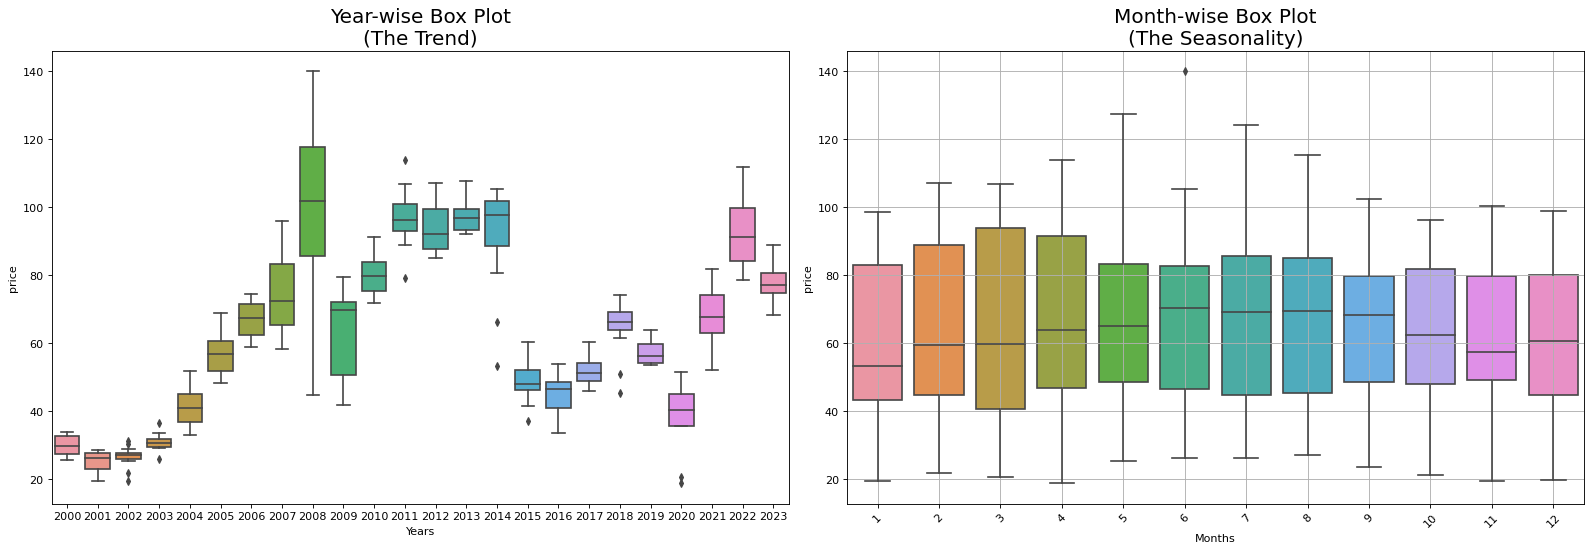

In [25]:
dataYear['price'] = pd.to_numeric(dataYear['price'])

# Sorting the DataFrame by 'Year' and then by 'Month'
df_sorted = dataYear.sort_values(by=['Years', 'Months', 'price'])

# Creating a 'Year_Month' column for easier plotting
df_sorted['Year_Month'] = df_sorted['Years'].astype(str) + '-' + df_sorted['Months'].astype(str).str.zfill(2)



# Prepare data
years = df_sorted['Years'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi=80)
sns.boxplot(x='Years', y='price', data=df_sorted, ax=axes[0])
sns.boxplot(x='Months', y='price', data=df_sorted.loc[~df_sorted.Years.isin([2000, 2023]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
df_sorted = Dff_DropColumn.dropna()
df_sorted

,date,price,percentChange,change,Months,Years,Price
192,2000-01-01 00:00:00+00:00,27.64,7.969,2.04,1,2000,27.64
193,2000-02-01 00:00:00+00:00,30.43,10.094,2.79,2,2000,30.43
194,2000-03-01 00:00:00+00:00,26.90,-11.600,-3.53,3,2000,26.90
195,2000-04-01 00:00:00+00:00,25.74,-4.312,-1.16,4,2000,25.74
196,2000-05-01 00:00:00+00:00,29.01,12.704,3.27,5,2000,29.01
...,...,...,...,...,...,...,...
475,2023-08-01 00:00:00+00:00,82.96,2.017,1.64,8,2023,82.96
476,2023-09-01 00:00:00+00:00,88.80,7.040,5.84,9,2023,88.80
477,2023-10-01 00:00:00+00:00,80.50,-9.347,-8.30,10,2023,80.50
478,2023-11-01 00:00:00+00:00,76.05,-5.528,-4.45,11,2023,76.05


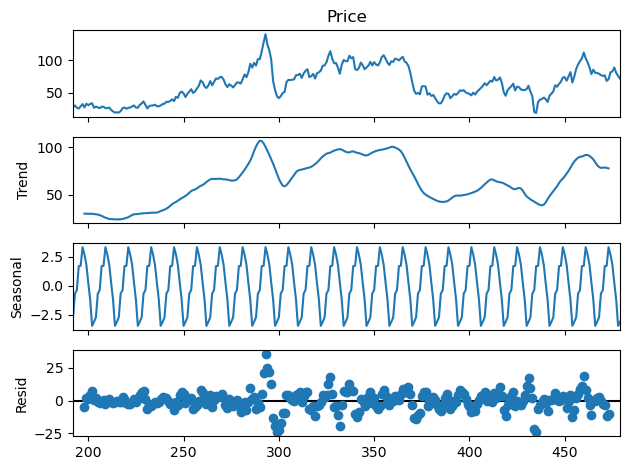

In [27]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
result = sm.tsa.seasonal_decompose(df_sorted['Price'].dropna(), model='additive', period=12)
# Plot the decomposed components
fig = result.plot()
plt.show()

In [28]:
def adfuller_test(prices, title=''):
    result=adfuller(prices)
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]
    summary = {
        'Series': title,
        'ADF Statistic': adf_statistic,
        'p-value': p_value,
        'Critical Value (1%)': critical_values['1%'],
        'Critical Value (5%)': critical_values['5%'],
        'Critical Value (10%)': critical_values['10%']
    }
    return summary

df_Main = df_sorted.drop(columns=['percentChange', 'date', 'change', 'Months', 'Years', 'price'])
# Run ADF test on each differenced series
results = []
results.append(adfuller_test(df_sorted['price'], 'Price'))

# Convert results to DataFrame
adf_results_df = pd.DataFrame(results)

adf_results_df

,Series,ADF Statistic,p-value,Critical Value (1%),Critical Value (5%),Critical Value (10%)
0,Price,-2.742689,0.066938,-3.453423,-2.871699,-2.572183


In [29]:
df_sorted['CrudeOil_First_Diff'] = df_sorted['price'].diff()

In [30]:
df_sorted = df_sorted.drop(columns=['percentChange', 'date', 'change', 'Months', 'Years', 'price'])
df_sorted = df_sorted.dropna()

In [31]:
# Run ADF test on each differenced series
results = []
results.append(adfuller_test(df_sorted['CrudeOil_First_Diff'], 'CrudeOil_First_Diff'))

# Convert results to DataFrame
adf_results_df = pd.DataFrame(results)

adf_results_df

,Series,ADF Statistic,p-value,Critical Value (1%),Critical Value (5%),Critical Value (10%)
0,CrudeOil_First_Diff,-13.679317,1.410451e-25,-3.453423,-2.871699,-2.572183


In [32]:
Rainfall = RainData.dropna()
Rainfadata = pd.melt(Rainfall, id_vars=['Month'], var_name='Year', value_name='Rainfall')
Rainfadata

,Month,Year,Rainfall
0,Jan,2001,0.0
1,Feb,2001,8.4
2,Mar,2001,121.6
3,Apr,2001,142.2
4,May,2001,231.2
...,...,...,...
115,Aug,2010,324.2
116,Sep,2010,311.3
117,Oct,2010,194.7
118,Nov,2010,135.1


In [33]:
# Replace the month names with numbers
Rainfadata['Month'] = Rainfadata['Month'].astype(str).str.strip()
Rainfadata['Year'] = Rainfadata['Year'].astype(str)

# Create a dictionary to map month names to numbers
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

# Replace the month names with numbers
Rainfadata['Month'] = Rainfadata['Month'].map(month_mapping)

# Sorting the DataFrame by 'Year' and then by 'Month'
Raindat = Rainfadata.sort_values(by=['Year', 'Month', 'Rainfall'])


# Convert Year to numeric type
Raindat['Year'] = Raindat['Year'].astype(int)

# Creating a new x-axis based on year with small offsets for each month
Raindat['Year_Month'] = Raindat['Year'] + (Raindat['Month'] - 1) / 12

Raindat

,Month,Year,Rainfall,Year_Month
0,1,2001,0.0,2001.000000
1,2,2001,8.4,2001.083333
2,3,2001,121.6,2001.166667
3,4,2001,142.2,2001.250000
4,5,2001,231.2,2001.333333
...,...,...,...,...
115,8,2010,324.2,2010.583333
116,9,2010,311.3,2010.666667
117,10,2010,194.7,2010.750000
118,11,2010,135.1,2010.833333


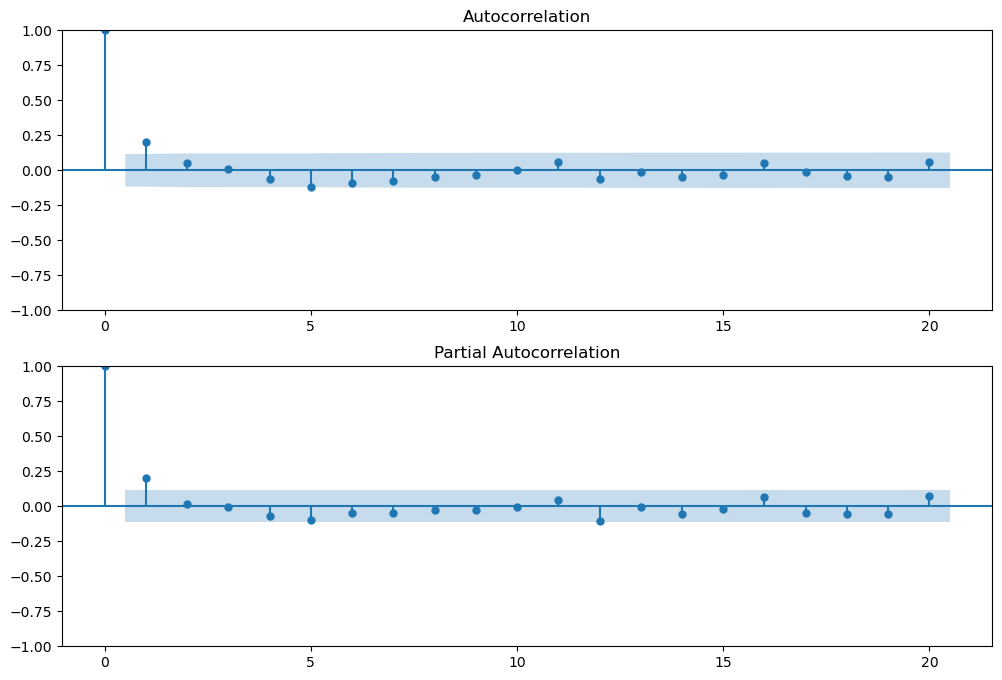

In [34]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_sorted['CrudeOil_First_Diff'].dropna(),lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_sorted['CrudeOil_First_Diff'].dropna(),lags=20,ax=ax2)

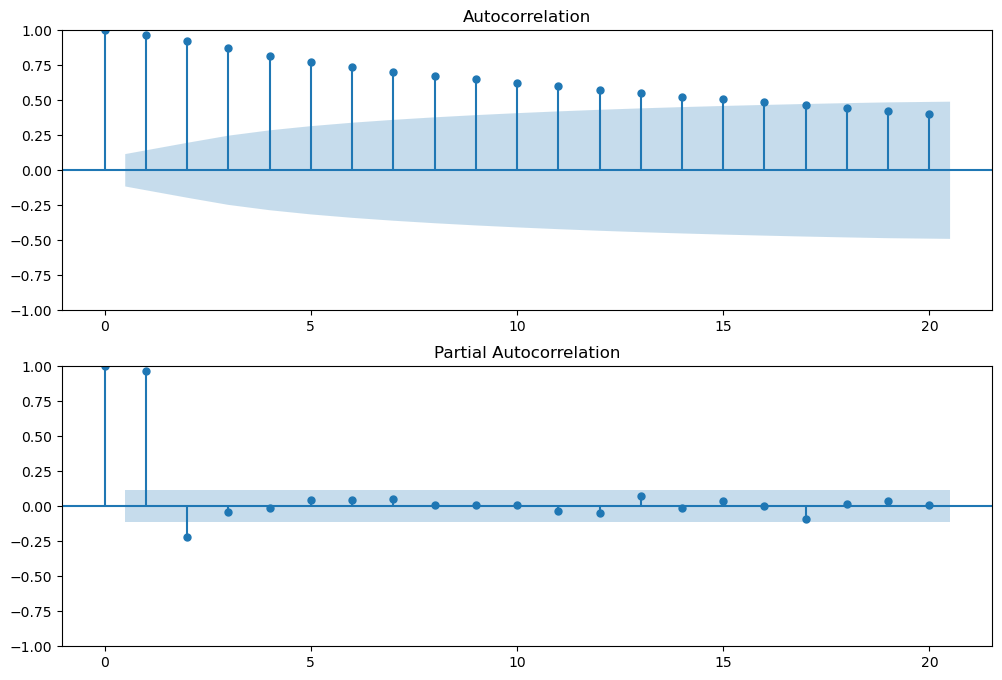

In [35]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_sorted['Price'].dropna(),lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_sorted['Price'].dropna(),lags=20,ax=ax2)

In [138]:
# Split data into train and test sets
import itertools
import warnings
from pmdarima import auto_arima
US_Data = df_sorted['Price'].dropna()
size = int(len(US_Data) * 0.70)
train, test = US_Data[0:size], US_Data[size:len(US_Data)]

# Fit the model
model = sm.tsa.ARIMA(train, order=(10,2,10))
model_fit = model.fit()

# Make predictions
y_pred = model_fit.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = model_fit.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 


# Make predictions
predictions = model_fit.get_prediction(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
pred_mean = predictions.predicted_mean
pred_conf = predictions.conf_int()

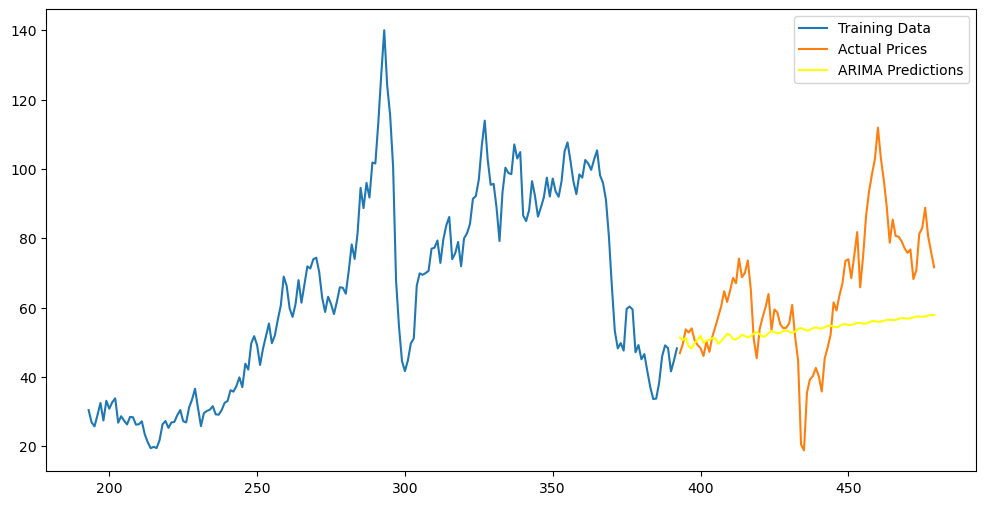

In [139]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Prices')
plt.plot(y_pred_out, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

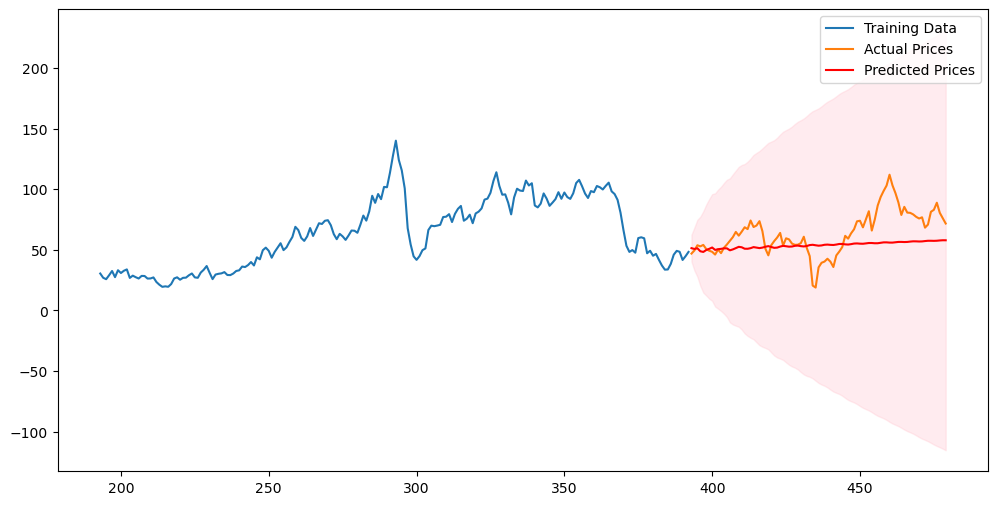

In [143]:
# Optionally, you can visualize the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Prices')
plt.plot(test.index, pred_mean, label='Predicted Prices', color='red')
plt.fill_between(test.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()


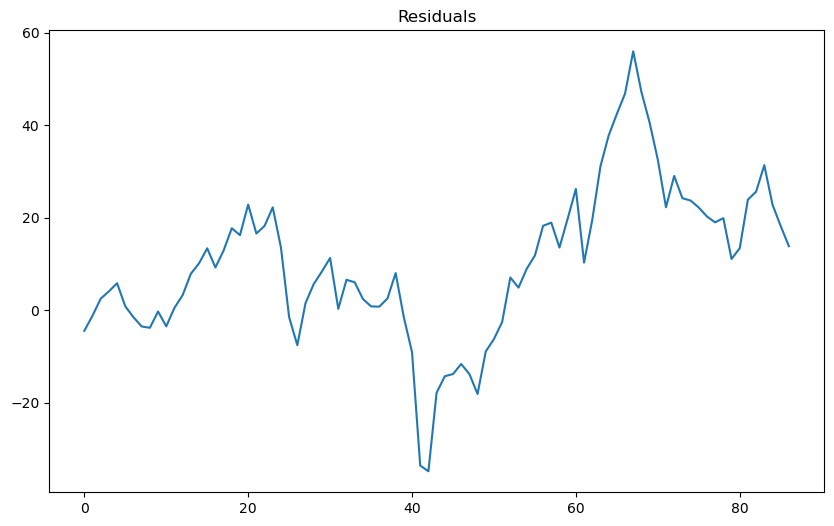

In [141]:
# Plot residuals
residuals = test.values - pred_mean.values
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

In [144]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Calculate errors
mae = mean_absolute_error(test.values, pred_mean.values)
mse = mean_squared_error(test.values, pred_mean.values)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test.values - pred_mean.values) / test.values)) * 100

# Print results
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')


Mean Absolute Error (MAE): 14.939179856936734
Mean Squared Error (MSE): 371.87593350361885
Root Mean Squared Error (RMSE): 19.284084979682568
Mean Absolute Percentage Error (MAPE): 23.93446404238487


       lb_stat     lb_pvalue
10  386.456639  7.163340e-77


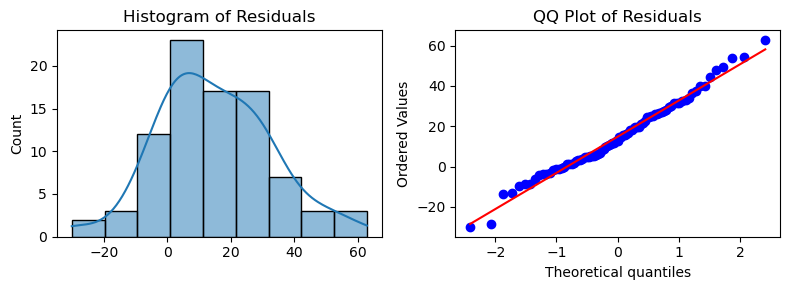

In [92]:

# Subtract pred_mean from test
residuals = test.values - pred_mean.values

# Convert the result back to a pandas Series
residuals = pd.Series(residuals, index=test.index)
ljung_box_test = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)

print(ljung_box_test)

# Histogram and QQ plot for each residual
plt.figure(figsize=(8, 3))
    
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
    
plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
    
plt.tight_layout()
plt.show()

In [48]:
df = df.dropna()

In [49]:
dt2001 = df[(df['Years'] >= 2001) & (df['Years'] <= 2010)] 
dt200 = dt2001.drop(columns=['percentChange', 'date', 'change', 'Months', 'Years'])

In [50]:
# Merge based on Month and Year
df_merged = pd.merge(dt2001, Raindat, left_on=['Months', 'Years'], right_on=['Month', 'Year'])

# Drop the unnecessary columns after merge
df_merged.drop(columns=['Months', 'Years', 'Month', 'Year', 'Year_Month'], inplace=True)
# Ensure date column is in correct format
df_merged['date'] = pd.to_datetime(df_merged['date']).dt.date
df_merged

,date,price,percentChange,change,Rainfall
0,2001-01-01,28.66,6.940,1.86,0.0
1,2001-02-01,27.39,-4.431,-1.27,8.4
2,2001-03-01,26.29,-4.016,-1.10,121.6
3,2001-04-01,28.46,8.254,2.17,142.2
4,2001-05-01,28.37,-0.316,-0.09,231.2
...,...,...,...,...,...
115,2010-08-01,71.92,-8.904,-7.03,324.2
116,2010-09-01,79.97,11.193,8.05,311.3
117,2010-10-01,81.43,1.826,1.46,194.7
118,2010-11-01,84.11,3.291,2.68,135.1


In [54]:
train_size = int(len(dt200) * 0.8)
Extrain = dt200.iloc[:train_size]
Extest = dt200.iloc[train_size:]

In [59]:
Exmodel = SARIMAX(Extrain, 
                order=(2,2,1), 
                seasonal_order=(2,2,1,12))

Exmodel_fit = Exmodel.fit(disp=False)

# Make predictions
Expredictions = Exmodel_fit.get_prediction(start=len(Extrain), end=len(Extrain) + len(Extest) - 1, dynamic=False)
Expred_mean = Expredictions.predicted_mean
Expred_conf = Expredictions.conf_int()

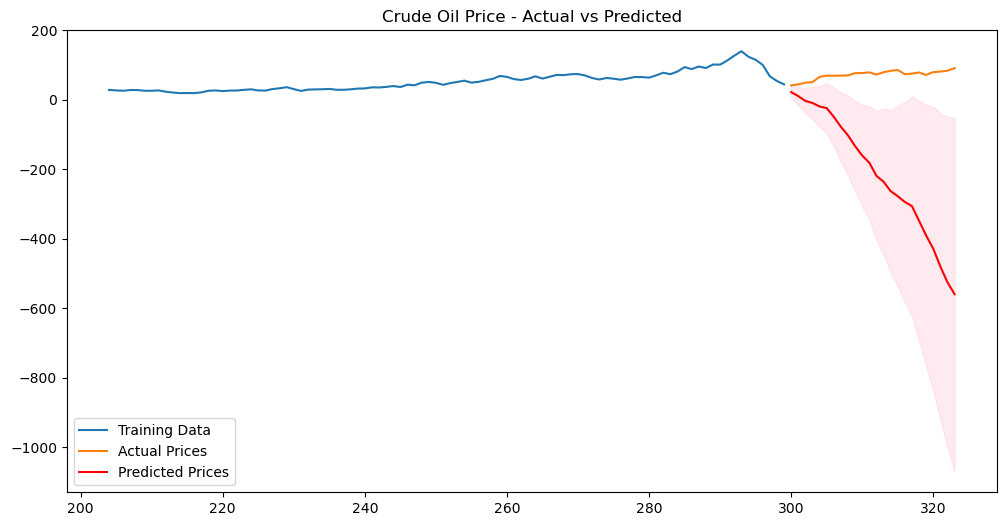

In [60]:
# Plot forecasts against actual outcomes
plt.figure(figsize=(12, 6))
plt.plot(Extrain.index, Extrain, label='Training Data')
plt.plot(Extest.index, Extest, label='Actual Prices')
plt.plot(Extest.index, Expred_mean, label='Predicted Prices', color='red')
# Plot confidence intervals
plt.fill_between(Extest.index, Expred_conf.iloc[:, 0], Expred_conf.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('Crude Oil Price - Actual vs Predicted')
plt.show()
